# Classification using Clustering : KMeans 

Here I will design a pipeline to first do clustering with Kmeans and then apply a classification algorithm on the labels. In principle any other clustering algorithm could be used

In [1]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pandas as pd
from src.utils import load_data

In [2]:
dfX, dfy = load_data(return_X_y=True)

In [3]:
from src.preprocessing import NaNDropper

In [4]:
prepare_data = Pipeline([
    ('nan_drpr', NaNDropper(['Embarked']))
])

dfX_pre, dfy_pre = prepare_data.fit_transform(dfX, dfy)

## Preprocessing

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from copy import deepcopy
from src.featurization import NameTitleExtractor

In [6]:
class KMeansTransformer(KMeans):       
    
    def transform(self, X, y=None):
        return self.predict(X).reshape(-1, 1)
    
    def fit_transform(self, X, y=None):
        return self.fit_predict(X).reshape(-1, 1)
        
        

In [7]:
def make_predictor_transformer(predictor):
    transformer = deepcopy(predictor)
    
    def transform(self, X, y=None):
        return self.predict(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.fit_predict(X).reshape(-1, 1)
    
    transformer.transform = transform
    transformer.fit_transform = fit_transform
    
    return transformer

In [8]:
KMeansTransformer = make_predictor_transformer(KMeans)

In [9]:
dfX[['Name']]

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
...,...
886,"Montvila, Rev. Juozas"
887,"Graham, Miss. Margaret Edith"
888,"Johnston, Miss. Catherine Helen ""Carrie"""
889,"Behr, Mr. Karl Howell"


In [10]:
imp_scale_cluster_enc = Pipeline([
    ('imp', SimpleImputer()),
    ('scale', StandardScaler()),
    ('cluster', KMeansTransformer()),
    ('enc', OneHotEncoder(drop='first'))
], 'passthrough')

imp_enc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder())
])

clmn_trnsfrm = ColumnTransformer([
    ('clmn_drpr', 'drop', ['Ticket', 'Cabin']), # Dropping PassengerId lowers the cv score
    ('pre_Name', 'drop', 'Name'),
    ('enc', OneHotEncoder(drop='first'), ['Sex']),
    ('imp_clust_enc', imp_scale_cluster_enc, ['Age', 'Fare']),
    ('imp_enc', imp_enc, ['Embarked'])
], 'passthrough')

preprocess = Pipeline([
    ('clmn_trnsfrm', clmn_trnsfrm),
    ('scale', StandardScaler())
])

In [11]:
# from src.featurization import NameTitleExtractor, CabinTypeExtractor, TicketTypeExtractor
# from src.featurization import SibSpBinner, ParchBinner 
# from src.featurization import family_size
# from sklearn.feature_selection import SelectFromModel
# from sklearn.svm import LinearSVC

# imp_enc = Pipeline([
#     ('imp', SimpleImputer(strategy='most_frequent')),
#     ('enc', OneHotEncoder())
# ])


# preprocess_noscale = ColumnTransformer([
#     ('enc', OneHotEncoder(drop='first'), ['Sex']),
#     ('imp_enc', imp_enc, ['Embarked']),
#     ('imp_clust_enc', imp_scale_cluster_enc, ['Age', 'Fare']),
#     ('pre_Name', NameTitleExtractor(), 'Name'),
#     ('pre_Cabin', CabinTypeExtractor(), 'Cabin'),
#     ('pre_Ticket', TicketTypeExtractor(), 'Ticket'),
#     ('pre_SibSp', SibSpBinner(), ['SibSp']),
#     ('pre_Parch', ParchBinner(), ['Parch']),
#     ('familysize', family_size, ['SibSp', 'Parch'])
# ], 
#     'passthrough')

# preprocess = Pipeline([
#     ('clmn_trnsfrm', preprocess_noscale),
#     ('scale', StandardScaler()),
#     ('feat_sel', SelectFromModel(LinearSVC(penalty='l1', dual=False)))
# ])

In [12]:
preprocess.fit_transform(dfX, dfy).shape

(891, 15)

In [13]:
from sklearn.feature_selection import RFE

## Cluster and Classify

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold()

In [15]:
pipe = Pipeline([
    ('preprocess', preprocess),
    ('ml', SVC())
])

In [16]:
pipe.fit(dfX, dfy)
pipe.score(dfX, dfy)

0.8473625140291807

In [17]:
cross_val_score(pipe, dfX, dfy, cv=skf).mean()

0.8271169418115625

In [18]:
from src.utils import print_params

## Try various models

Best param: {'ml': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)}

Best score: 0.8271169418115625


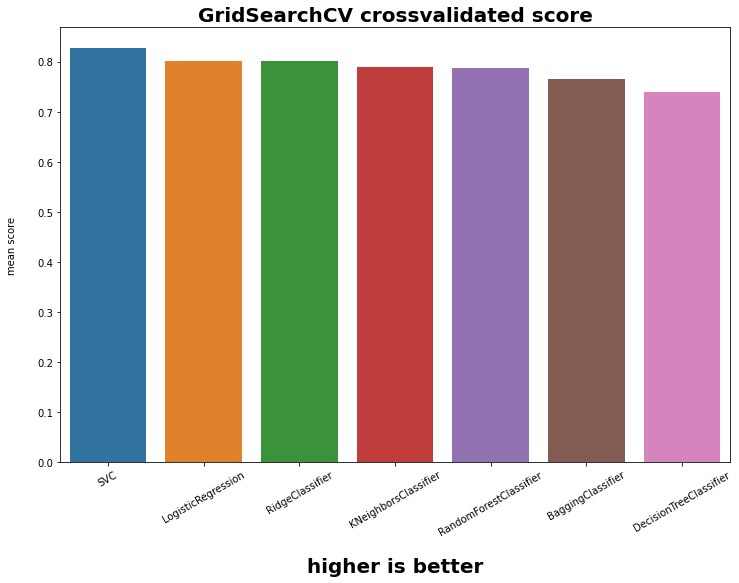

In [19]:
from src.tune import try_various_models
search = try_various_models(pipe, dfX, dfy, plot=True)

## Did clustering help improve score?

In [20]:
from src.tune import compare_param_effect_models

In [21]:
param_steps = ['preprocess__clmn_trnsfrm__imp_clust_enc']
alt = SimpleImputer()
search = compare_param_effect_models(pipe, dfX, dfy, param_steps, alt=alt)

Best param: {'ml': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'preprocess__clmn_trnsfrm__imp_clust_enc': Pipeline(memory='passthrough',
         steps=[('imp',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('cluster',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=8, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0)),
                ('enc',
                

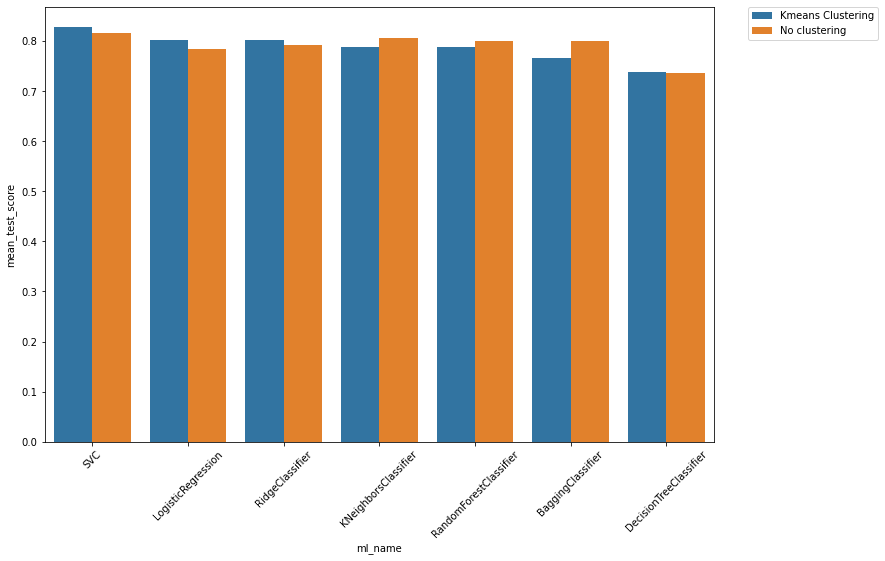

In [22]:
from src.plotting import plot_param_effect_models
g = plot_param_effect_models(search, 'preprocess__clmn_trnsfrm__imp_clust_enc', 
                             labels=['Kmeans Clustering', 'No clustering'])

## `Intrinsic Evaluation`: Deciding the number of clusters 

In [169]:
from sklearn.model_selection import GridSearchCV

In [171]:
%%time
param_grid = {'preprocess__clmn_trnsfrm__imp_cluster_enc__cluster__n_clusters': range(2, 12, 2)}

grid = GridSearchCV(pipe, param_grid, cv=skf)
grid.fit(dfX_pre, dfy_pre);
print(grid.best_score_)
print(grid.best_params_)

0.8335491652383672
{'preprocess__clmn_trnsfrm__imp_cluster_enc__cluster__n_clusters': 8}
CPU times: user 898 ms, sys: 20 µs, total: 898 ms
Wall time: 898 ms


## `Feature Augmentation`: Augment KMeans Features using `FeatureUnioun`

In [172]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [173]:
class ColumnSelector(BaseEstimator, ClassifierMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X


### Cluster and Augment only continous features

In [224]:
from sklearn.pipeline import FeatureUnion

cluster_enc = Pipeline([
    ("clust", KMeansTransformer()),
    ('enc', OneHotEncoder(drop='first'))
])

cluster_augment = FeatureUnion([
    ("clust_enc",cluster_enc),
    ("orig", ColumnSelector())
])


imp_scale_augment = Pipeline([
    ('imp', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('clust_aug', cluster_augment)
], 'passthrough')

imp_enc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder())
])

clmn_trnsfrm = ColumnTransformer([
    ('clmn_drpr', 'drop', ['Name', 'Ticket', 'Cabin']),
    ('enc', OneHotEncoder(drop='first'), ['Sex']),
    ('imp_scale_aug', imp_scale_augment, ['Age', 'Fare']),
    ('imp_enc', imp_enc, ['Embarked'])
], 'passthrough')

preprocess = Pipeline([
    ('clmn_trnsfrm', clmn_trnsfrm),
    ('scale', StandardScaler())
])

In [229]:
preprocess.fit_transform(dfX_pre, dfy_pre).shape

(889, 17)

In [226]:
pipe = Pipeline([
    ('preprocess', preprocess),
    ('ml', SVC())
])
pipe.fit(dfX_pre, dfy_pre)
pipe.score(dfX_pre, dfy_pre)

cross_val_score(pipe, dfX_pre, dfy_pre, cv=skf).mean()

%%time
param_grid = {
    'preprocess__clmn_trnsfrm__imp_scale_augment__augment__cluster_enc__cluster__n_clusters': range(2, 12, 2)}
grid = GridSearchCV(pipe, param_grid)
grid.fit(dfX_pre, dfy_pre)
grid.best_score_

0.8458942632170978

# Cluster and Augment the whole dataset

In [247]:

cluster_enc = Pipeline([
    ("clust", KMeansTransformer()),
    ('enc', OneHotEncoder(drop='first', sparse=False)),
    ('scale', StandardScaler())
])

cluster_augment_scale = FeatureUnion([
    ("clust_enc",cluster_enc),
    ("orig", ColumnSelector())
])

imp_enc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(sparse=False))
])

clmn_trnsfrm = ColumnTransformer([
    ('clmn_drpr', 'drop', ['Name', 'Ticket', 'Cabin']),
    ('enc', OneHotEncoder(drop='first', sparse=False), ['Sex']),
    ('imp', SimpleImputer(), ['Age', 'Fare']),
    ('imp_enc', imp_enc, ['Embarked'])
], 'passthrough')

preprocess = Pipeline([
    ('clmn_trnsfrm', clmn_trnsfrm),
    ('scale', StandardScaler()), # scale before clustering
    ('clust_aug', cluster_augment)
])

In [248]:
preprocess.fit_transform(dfX_pre).shape

(889, 17)

In [249]:
pipe = Pipeline([
    ('preprocess', preprocess),
    ('ml', SVC())
])
pipe.fit(dfX_pre, dfy_pre)
print(f'Trainig score: {pipe.score(dfX_pre, dfy_pre)}')
print(f'crossvalidation score: {cross_val_score(pipe, dfX_pre, dfy_pre, cv=skf).mean()}')

Trainig score: 0.8413948256467941
crossvalidation score: 0.818923379673713


In [253]:
%%time
param_grid = {
    'preprocess__clust_aug__clust_enc__clust__n_clusters': range(2, 12, 2)}
grid = GridSearchCV(pipe, param_grid, cv=skf)
grid.fit(dfX_pre, dfy_pre)
grid.best_score_

CPU times: user 6.11 s, sys: 79.7 ms, total: 6.19 s
Wall time: 2.39 s


0.8177997841680951